## Phone Recognizer

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  23/04/23
+ ###### Requires: pyspch v0.7   

Content:
Evaluate an HMM phone recognition system.  In all situations we use simplistic single state phone models.   
Various phone/state transition models are compared 
- no transition model, i.e. frame based recognition
- ergodic transition model, i.e. free transition between phones
- bigram transition model
 

In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
from pyspch.stats import GMM
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio
import copy
# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import torch
import pyspch
import pyspch.nn
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)
logging.basicConfig(level=logging.INFO)
# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

In [3]:
#@title Auxiliary functions
# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename, new_read_path=None, old_read_path='/users/spraak/spchlab/public_html/data/timit/'):
    
    # load module
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)

    # replace esat_path with root_url
    if new_read_path is not None:
        for k, v in setup.items():
            if type(v) == str:
                setup[k] = v.replace(old_read_path, new_read_path)
            
    return setup

def get_pickle(filename):
    picklefile = pyspch.read_fobj(filename)    
    #picklefile = open(filename, 'rb')
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

def plot_probs(probs, labels,  fig, iax=2, x0=0., title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## !! only works properly for starting frame = 0
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,linewidths=1,linecolor='k')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.])
        fig.axes[iax].legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

In [4]:
# Helper routines for TIMIT test samples
#
timit_test_files =  ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236'] 

def extract_timit_data(name='',timit_root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'):
    '''
    extracts waveform and metadata for a named TIMIT file:
    
    wavdata  wav data
    sr     sample_rate
    wrd    wrd segmentation
    phn    phn segmentation
    '''
    # audio and feature extraction
    wavdata, sr = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
    # get  word and phoneme segmentations
    wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sr)   
    phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sr,xlat='timit61_timit41')
    return(wavdata,sr,wrd,phn)

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

In [5]:
def tmat_from_transcription(phn_seq,phn_set,probstyle='lin',eps=0.):
    '''
    Create a pseudo transition matrix accepting all phone transitions in a phn_seq
    The transition matrix contains 0 and 1 values

    Sentences are forced to start and end in silence
    '''
    n_phones = len(phn_set)
    trans_mat = np.ones((n_phones,n_phones))*eps
    phn_set = list(phn_set)
    for i in range(n_phones): trans_mat[i,i]=1.
    idx = [ phn_set.index(phn) for phn in phn_seq ]
    for i in range(0,len(idx)-1):
        trans_mat[ idx[i], idx[i+1] ] = 1
    init_mat = np.ones(n_phones)*eps
    init_mat[ idx[0] ] = 1.
    end_states = np.array([idx[-1]])
    return(trans_mat,init_mat,end_states)

# convert array of phones into index array usable for slicing
def labs2indx(arr):
    return np.array([ lab2idx[p] for p in arr ])

def tmat_from_lex(lexicon,PROB=True,eps=1.e-2,selfct=5):
    '''
    A phone bigram model is derived from a lexicon.
    Silence is allowed between words and thus added as a word start or word end option
    Sentences are forced to start or end in silence
    if PROB is True a probabilistic bigram model is returned is PROB is False a deterministic biphone model
    is returned
    '''
    n_phones = len(phn_set)
    bigram_cts = np.zeros( (n_phones,n_phones) , dtype='int64')

    # convert lexicon to phone indices
    lex_indx = { w:labs2indx(phns) for w,phns in lexicon.items()}    
    silidx = lab2idx['sil']
    end_states = [silidx]
    for w,idxs in lex_indx.items():
        n = len(idxs)-1
        for i in range(n):
            bigram_cts[idxs[i],idxs[i]] += selfct
            bigram_cts[idxs[i],idxs[i+1]] += 1
        bigram_cts[silidx,silidx] += selfct
        bigram_cts[silidx,idxs[0]] += 1
        bigram_cts[idxs[n],silidx] += 1
        bigram_cts[idxs[n],idxs[n]] += selfct
        # cross word ? not with lexicon
        # for w1,idxs1 in lex_indx.items():
        #    bigram_cts[idxs[n],idxs1[0]] += 1
        # ending states of each word are added to end_states
        end_states.append(idxs[n])
    if PROB:
        bigrams = (bigram_cts / np.sum(bigram_cts+eps,axis=1)) + eps      
    else:
        bigrams = np.where(bigram_cts > 0 , 1., eps)
     
    initmat = np.zeros(n_phones)
    initmat[silidx] = 1.

    
    end_states =  np.unique(end_states)
    return(bigrams,initmat,end_states)

def read_lexicon(name,url_root = "https://homes.esat.kuleuven.be/~spchlab/data/",CLOSURES=True):
    ''' 
    reads a lexicon file 
    closures are not in the lexicon transcriptions but can be added if CLOSURES is TRUE
    '''
    lines = Spch.read_txt(url_root+name)
    lex = {}
    for line in lines:
        w = line.split()
        lex[w[0]] = w[1:]
    if(CLOSURES):
        return(add_closures(lex))
    else:
        return(lex)

def add_closures(lex):
    ''' add closures to transcriptions with within word plosives '''
    lex1 = {}
    for w,phn in lex.items():
        phn1 = phn[0:1]
        for p in phn[1:]:
            if p in ['k','t','p','b','d','g']:
                phn1.append('cl')
            phn1.append(p)
        lex1[w]=phn1
    return(lex1)

def make_hmm_ergodic_cl(hmm,phn_set,selfprob=.8,plosive_set=['k','p','t','g','b','d']):
    ''' makes ergodic HMM transition model
    but with specifically for models in which we force the cl state to only transition to a plosive state '''
    hmm.init_topology("ergodic",selfprob=selfprob)
    idx_cl = lab2idx['cl']
    tmat = hmm.transmat
    tmat[idx_cl] = 0.
    tmat[idx_cl][idx_cl] = selfprob
    for phn in plosive_set:
        tmat[idx_cl][lab2idx[phn]] = (1-selfprob)/float(len(plosive_set))
        
def lexicon_selection(lexicon,selection):
    ''' makes a selection selection '''
    lex_select = {x: lexicon[x] for x in selection}
    return(lex_select)

def get_dnn_probs(ftrs,model,setup):
    ''' utility for returning DNN posterior probs '''
    # splice features for DNN processing
    ftrs_dnn = pyspch.sp.splice_frames(ftrs,setup.sampler_args['N'], setup.sampler_args['stride']) # input
    # input and target to tensor
    X = torch.tensor(ftrs_dnn).T.float().to(device)
    # posteriors 
    yp_t = model(X) # log probs
    yp_t = torch.nn.Softmax(dim=1)(yp_t) # probs 
    return(yp_t.cpu().detach().numpy())

def add_prob_plot(ax, probs, labels, x0=0., title="", style="line"):
    ''' Plotting utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ## 
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,linewidths=1,linecolor='k',cbar=False)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        ax.plot(probs)
        ax.set_ylim([0.,1.])
        ax.set_xlim([0, probs.shape[0]])
        ax.legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

### 1. Setting Up

##### Feature Extraction
MFCC39 =  MFCC13 + Deltas + DeltaDeltas + mean-variance normalization, (defined by feature_args).   
MFCC26 just uses the first 26 Dimensions (drops deltadelta's)

##### Acoustic model
We load 2 models.  Both models were trained on the TIMIT data set and use 41 phones  (39 regular phones + silence + closure)
- A **GMM-Model** *S41_D26_G64_FULL_1.pkl*        
    + uses D26 = 26 dim features, G64 = 64 Gaussians, FULL_1 = training database + version number
    + The input spans a single frame, i.e. roughly 50msec 
- A **DNN model** *mfcc13dd2mv/N5s2/model.pt*
    + This model splices 11 frames with stride 2 together to form an 11x39=429D feature vector.
    + The  input view now spans over 200msec

##### Phonetic Lexicon
we import a small background lexicon from which we will select some words

In [6]:
# task setup
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
# the trained models are supposed to use these classes
phn_set = pyspch.timit.get_timit_alphabet('timit41')
lab2idx = {lab: i for i, lab in enumerate(phn_set)}
idx2lab = {v: k for k, v in lab2idx.items()}
f_shift = 0.01
#
# define feature extraction: MFCC13 + delta's + mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#  
clf_GMM = get_pickle(root_url+'timit/models/gmm/'+"S41_D26_G64_FULL_1.pkl") # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database

C:\Users\compi\miniforge3\envs\py310t\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
# read the DNN model
# = mfcc13, delta_delta2, meanvar, 11 frames, stride 2
model_path = 'timit/models/default/mfcc13dd2mv/N5s2/' 
#model_path = 'timit/models/default/mfcc13dd2mv/N0s1/' 
# read checkpoint 
model_fobj = pyspch.read_fobj(root_url + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)

# unpack checkpoint (model, etc)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
#idx2lab_dnn = {v: k for k, v in lab2idx.items()}

setup = dotdict(setup)
model.to(device);

In [8]:
# import a background lexicon
main_lexicon = read_lexicon('lexlm/lexicon1.txt')
lex_computers = {
    'friendly':['f', 'r', 'eh', 'n', 'cl', 'd', 'l', 'iy'],
    'computers': ['k', 'ah', 'm', 'cl', 'p', 'y', 'uw',  't', 'eh', 'r','s'],
    'computers1': ['k', 'ah', 'm', 'cl', 'p', 'y', 'uw',  't', 'er', 'z']}


### 2. Select Input File
Run either one of the two cells below.
First one selects a sample from TIMIT; second one selects other (personal) samples
Timit files come with phonetic transcriptions that can be used to verify recognized sequences

In [9]:
# SELECT a TIMIT FILE
name = timit_test_files[2]
times = np.array([.0,1.])
wavdata, sr, seg_wrd, seg_phn = extract_timit_data(name=name)
transcript = ' '.join(list(seg_wrd['seg']))
transcript

'bricks are an alternative'

In [10]:
# SELECT a PERSONAL TEST FILE
name = root_url + 'demo/friendly'
# audio and feature extraction ; return 16kHz sampling rate
wavdata, sr = pyspch.audio.load( name + ".wav",sample_rate=16000)
seg_wrd = pyspch.timit.read_seg_file( name + ".wrd")   
seg_phn = pyspch.timit.read_seg_file( name + ".phn")
try:
    transcript = ' '.join(seg_wrd['seg'])
except: 
    transcript = ''
times = None
#times = np.array([0.,1.04])

#### FEATURE EXTRACTION
Compute both a standard spectrogram and features as requested by the recognizer

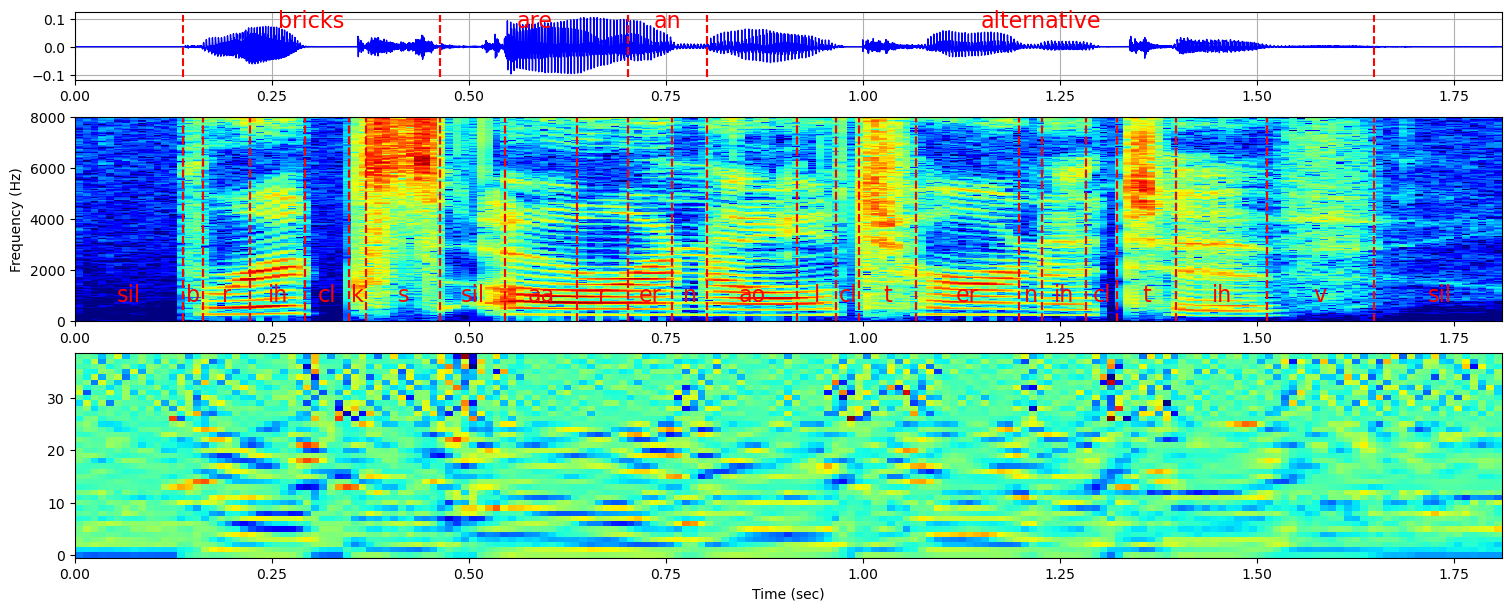

In [10]:
spgdata = pyspch.sp.feature_extraction(wavdata, sample_rate=sr)
ftrs = pyspch.sp.feature_extraction(wavdata, **feature_args)
#
n_y, n_frames = spgdata.shape
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=(sr/2.)/(n_y-1),
                                   sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])

fig.add_seg_plot(seg_phn, iax=1, ypos=.13, color='r') 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='r') 
display(fig)
display(Audio(data=wavdata,rate=sr))
#
# we can plot selective part of the spectrograms and trellises 
# by specifying a time slot ; by default the whole sentence is plotted
#
if times is None:
    times = np.array([0. , (len(wavdata)-1)/float(sr)])
frames= (times/f_shift).astype('int')
frame_sel = slice(frames[0],frames[1])    
if seg_phn is not None:
    labels = pyspch.seg2lbls(seg_phn, n_frames=ftrs.shape[1],pad_lbl='sil')
    seg_phn_sel = seg_phn[(seg_phn['t0']<frames[1]*f_shift) & (seg_phn['t1']>frames[0]*f_shift)]
    phn_sel, indx_sel = select_phones_idx((seg_phn_sel['seg'],['sil']),phn_set,SORTED=True)
#

In [11]:
### DISPLAY ROUTINE for RECOGNITION EXPERIMENTS
# Run the next cell to show Frame Probabilities and Recognition result for any of the
# previous model.
# select the most prominent phonemes for plotting
# !!! USE WITH CARE  !!!
# This routine uses plenty of (global) VARIABLES that are assumed predefined/computes
# It should work well, where indicated in this notebook, but shouldn't be taken as generic
def plot_it(top_k=30):
    indx_sel = np.argsort(np.sum(y_prob,axis=0))[::-1][0:top_k]
    phn_sel = [phn_set[i] for i in indx_sel]
    #
    fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=(sr/2.)/(n_y-1),row_heights=[1,1,2,.5,2,.5],
                                     frames=frames,sample_rate=sr, figsize=(16,12), img_ftrs=[])
    add_prob_plot(fig.axes[2],y_obs_prob[frame_sel,indx_sel],phn_sel,style='img',title="Observation Probabilities")
    add_prob_plot(fig.axes[4],trellis.probs[frame_sel,indx_sel],phn_sel,style='img',title="Trellis Probabilities")
    if seg_phn is not None:
        fig.add_seg_plot(seg_phn, iax=1, ypos=.83, color='r') 
    if seg_wrd is not None:
        fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='r') 
    fig.add_seg_plot(y_obs_seg, iax=3, ypos=.5, Lines=True, color='k')
    fig.add_seg_plot(y_seg, iax=5, ypos=.5, Lines=True, color='k')
    return(fig)

## 2. Phone Recognition
### Observation Probabilities
We first compute frame based observation probabilities   
We do this for our selected Acoustic Model (GMM or DNN)

In [12]:
y_obs_prob = get_dnn_probs(ftrs,model=model,setup=setup)

### FRAME RECOGNITION
The most naive way of doing speech recognition is by looking
at the observation probabilities on a frame by frame basis and taking
frame by frame the maximum.  (by preference you do this on the posteriors) 
and merging adjacent frames with identical recognized
phone labels together into phone segments

In [13]:
y_obs_idx = np.argmax(y_obs_prob, axis=1)
y_obs_lbl = [phn_set[i] for i in y_obs_idx]
y_obs_seg = Spch.lbls2seg(y_obs_lbl)
y_obs_rec = ' '.join(list(y_obs_seg.seg))
print("Recognized:  ",y_obs_rec)

Recognized:   sil b r w r ey iy r ih iy ih ey ih cl k s sil aa ao aa r ao r er r ih er ih r n ow ao oy ow l cl t k hh er r er ih n m ih cl t ih v cl sh sil d sil jh sil


### HMM RECOGNITION
In this setup we the simples possible HMM model to do speech recognition, i.e. single state phone models. 
We use the Viterbi algorithm to find the optimal alignment between input (features) and states.
We will compare two different topologies

1. A pure ergodic model where a transition is possible from any state to any other state, the transition probabilities are independent of the phone (pair) and set by a single parameter 'selfprob', i.e. the probability on the self loops.

2. A phone model incorporating some word and language model information, i.e. the transitions are learned from example words
in a lexicon.  These values are always smoothed with an ergodic model to allow all possible phoneme sequences

In the figures below, you see:   
1.  waveform + spectrogram    
2.  phone probabilities per frame (=observation probs) + frame recognition    
3.  trellis probabilities + viterbi alignment    

You can select the top_k phonemes (according to average frame probability) for plotting. 

#### RECOGNITION with ERGODIC PHONE MODEL
  
In an ergodic model we allow transitions from any phone to any other phone (even if this is not plausible in a language).
The main contribution in this ergodic model comes from given a higher probability to self-loop than transition probabilities.  This makes overly short phonetic segments (1 or 2 frames) highly unlikely.
The recognition is obtained by backtracking over a trellis.

Recognized:   sil r ih cl k s sil aa r ih n ow l cl t er n ih cl t ih v sil


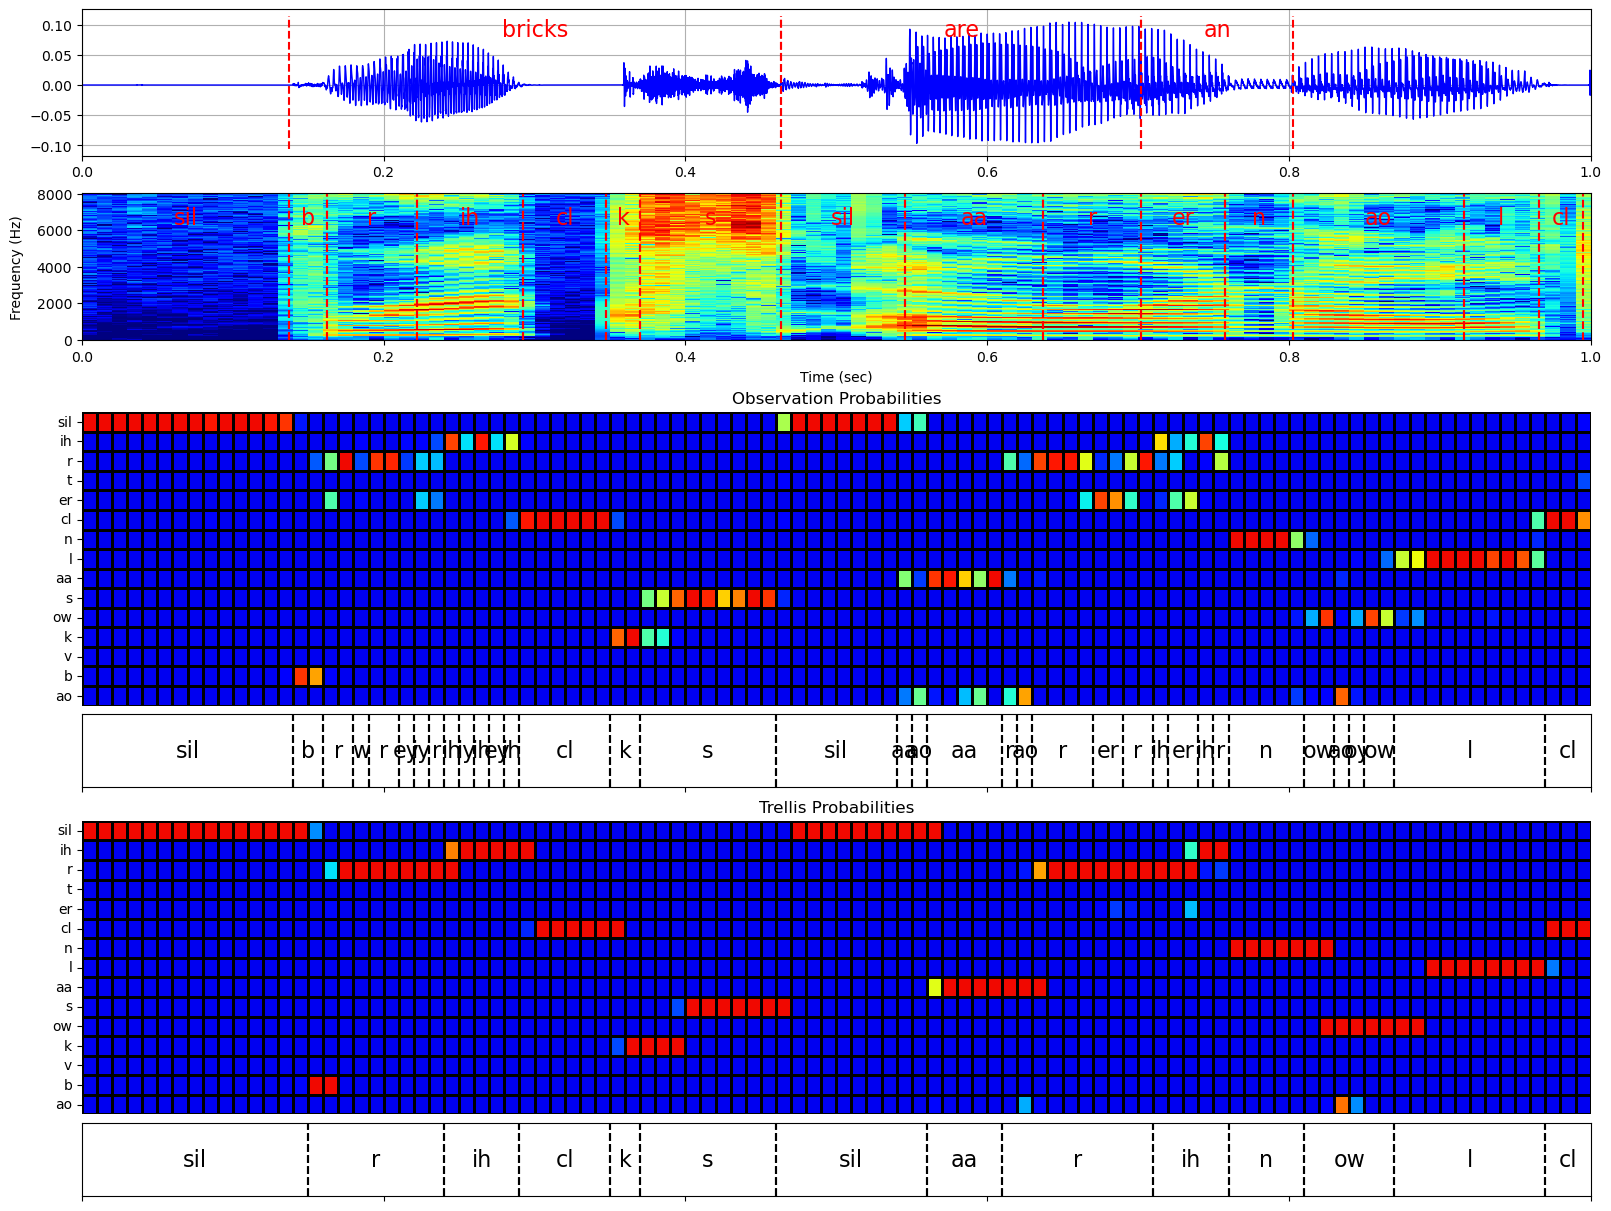

In [14]:
hmm = libhmm.HMM(prob_style="lin",states=phn_set)
#hmm.init_topology("ergodic",selfprob=.8)
make_hmm_ergodic_cl(hmm,phn_set=phn_set,selfprob=.9)
# Run a trellis based recognizer
trellis=libhmm.Trellis(hmm,Normalize=True)
trellis.viterbi_pass(y_obs_prob)
y_prob = trellis.probs
y_lbl = hmm.states[trellis.backtrace()]
y_seg = Spch.lbls2seg(y_lbl)
y_rec = ' '.join(list(y_seg.seg))
print("Recognized:  ",y_rec)
plot_it(top_k=15)

#### RECOGNITION with PHONE BIGRAM TRANSITIONS estimated on a lexicon
In this setup we use HMM single state phonetic phone models as before.
The connections between the phones are now governed by a probabilistic bigram model derived from example words.
And words can come connected via silence.
This is an extremely crude way to add lexical information; but its effect can already be large.
A small probability is added to all connections as in the ergodic model to be able to come up with
any transcription if the acoustics are strong enough. 

Recognized:   sil b r ih cl k s sil aa r ih n sil ao l cl t er n ih cl t ih v sil


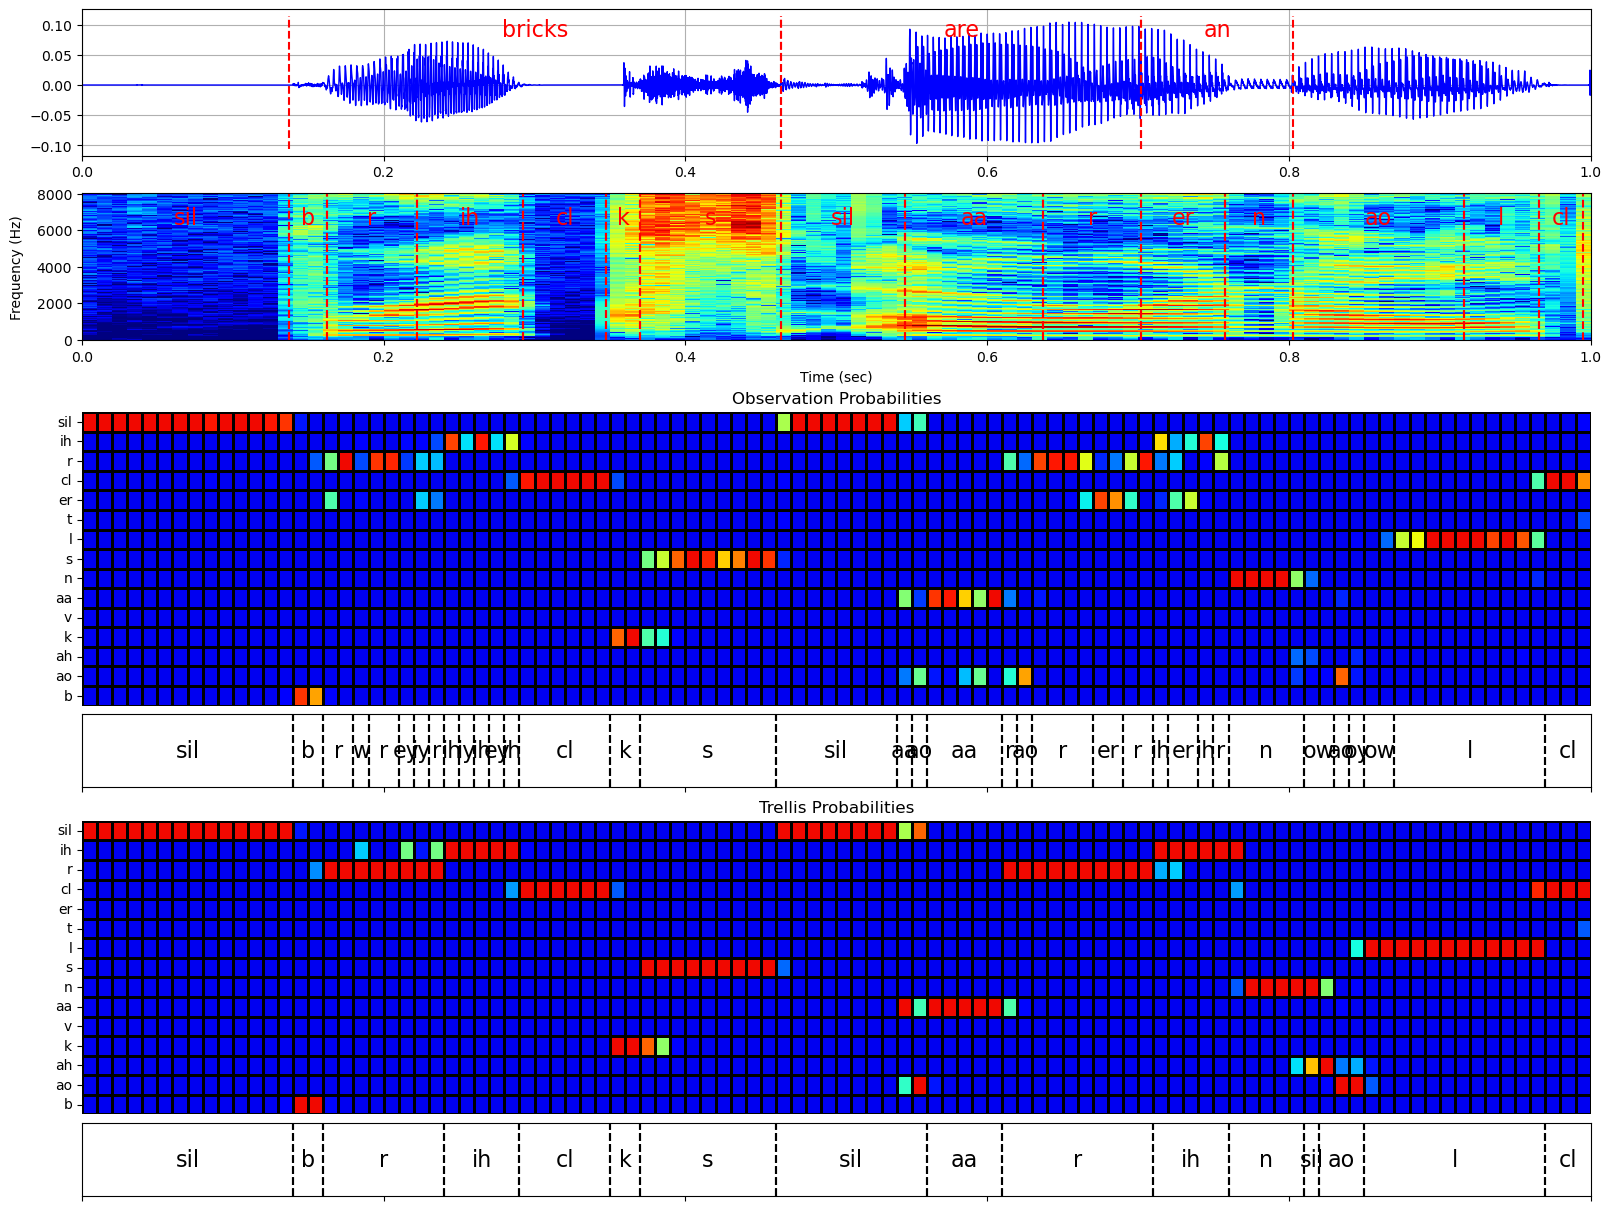

In [15]:
# word_selection = ['the','ultimate','user','friendly','computers','expansionist']
word_selection = transcript.split()
lex = lexicon_selection(main_lexicon,word_selection)
#lex = lex_computers # lexicon
trans_mat,init_mat,end_states = tmat_from_lex(lex,PROB=False,eps=1.e-5)
hmm = libhmm.HMM(prob_style="lin",states=phn_set,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# Run a trellis based recognizer
trellis=libhmm.Trellis(hmm,Normalize=True)
trellis.viterbi_pass(y_obs_prob)
y_prob = trellis.probs
y_lbl = hmm.states[trellis.backtrace()]
y_seg = Spch.lbls2seg(y_lbl)
y_rec = ' '.join(list(y_seg.seg))
print("Recognized:  ",y_rec)
plot_it(top_k=15)

In [16]:
word_selection

['bricks', 'are', 'an', 'alternative']

In [17]:
def make_hmm_ergodic_cl(hmm,phn_set,selfprob=.8,plosive_set=['k','p','t','g','b','d']):
    ''' makes ergodic HMM transition model
    but with specifically for models in which we force the cl state to only transition to a plosive state '''
    hmm.init_topology("ergodic",selfprob=selfprob)
    idx_cl = lab2idx['cl']
    tmat = hmm.transmat
    tmat[idx_cl] = 0.
    tmat[idx_cl][idx_cl] = selfprob
    for phn in plosive_set:
        tmat[idx_cl][lab2idx[phn]] = (1-selfprob)/float(len(plosive_set))